# Avaliação de Modelos

In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Importação dos classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
# Carregar os dados gerados (merged_data.csv)
data = pd.read_csv("merged_data.csv")

In [3]:
# Seleciona apenas as colunas numéricas pois não queremos utilizar séries temporais
data = data.select_dtypes(include=[np.number])

In [4]:
# Excluir colunas indesejadas que podem causar overfitting em nosso modelo
colunas_excluir = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "variation",
    "vix_open",
    "vix_high",
    "vix_low",
    "vix_close",
    "vix_variation",
    "vix_mean",
]
data = data.drop(columns=colunas_excluir)

In [5]:
data.head()

,open_ma3,close_ma3,volume_ma3,high_ma3,low_ma3,open_shift,close_shift,indication,vix_open_ma3,vix_close_ma3,vix_variation_ma3,vix_mean_ma3
0,4099.493333,4080.756667,513.378615,4171.796667,3931.470000,4120.98,4086.29,0,13.926667,14.333333,2.873333,14.080000
1,4068.703333,4047.430000,708.503647,4145.173333,3781.470000,4069.13,4016.00,1,14.190000,12.933333,1.993333,13.576667
2,4041.710000,4056.670000,886.521494,4163.413333,3775.226667,4016.00,4040.00,1,12.900000,12.263333,1.486667,12.680000
3,4067.666667,4156.673333,918.413392,4247.433333,3832.966667,4040.00,4114.01,1,12.056667,11.943333,1.356667,12.108333
4,4167.670000,4236.900000,787.389353,4363.796667,4115.460000,4147.00,4316.01,0,11.923333,11.920000,1.276667,11.985000


In [6]:
# Separar variáveis de entrada e saída
X = data.drop("indication", axis=1)
y = data["indication"]

In [7]:
# Quantidades de classes
print(y.value_counts())

indication
0    1090
1     831
Name: count, dtype: int64


In [8]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

A função evaluate_model avalia o desempenho de um modelo de machine learning em um conjunto de teste (X_test, y_test). Primeiro, ela usa o modelo para fazer previsões sobre X_test. Em seguida, imprime a matriz de confusão, que mostra a quantidade de acertos e erros para cada classe, e o relatório de classificação, que inclui métricas como precisão, recall e F1-score para cada classe. Por fim, a função retorna o F1-score macro, que calcula a média das pontuações F1 de todas as classes, dando igual peso a cada uma, o que é útil quando há um desequilíbrio entre as classes.

1.	**Entrada da função**: Recebe um modelo treinado (model), os dados de teste (X_test) e os rótulos reais (y_test).

2.	**Previsões do modelo**: Utiliza model.predict(X_test) para gerar as previsões com base nos dados de teste.

3.	**Matriz de confusão**: Exibe a matriz de confusão, que mostra os acertos e erros do modelo em cada classe.

4.	**Relatório de classificação**: Imprime um relatório contendo métricas como precisão, recall e F1-score para cada classe.

5.	**Retorno do F1-score macro**: Calcula e retorna o F1-score macro, que é a média do F1-score de todas as classes, tratando-as com a mesma importância, independentemente do tamanho do conjunto de dados de cada classe.

In [10]:
# Função para avaliar o modelo (exibe a matriz de confusão, relatório e retorna o f1_macro)
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, predictions))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, predictions))
    return f1_score(y_test, predictions, average='macro')

In [12]:
# Dicionário com alguns classificadores e seus hiperparâmetros para busca em grade
modelos = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=10000, solver="lbfgs"),
        "params": {
            "C": [0.1, 1, 10, 100],
            "class_weight": [None, "balanced"]
        }
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ["uniform", "distance"]
        }
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "GradientBoostingClassifier": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7]
        }
    },
    "AdaBoostClassifier": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1, 10]
        }
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10, 100],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        }
    },
    # "RedeNeural": {
    #     "model": MLPClassifier(max_iter=5000, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [
    #             (50,), (100,), (200,), 
    #             (50,50), (100,50,25), (100,100,), (150,100,50)
    #         ],
    #         "activation": ["relu", "tanh", "logistic"],
    #         "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    #         "solver": ["adam", "sgd"],
    #         "learning_rate": ["constant", "adaptive"],
    #         "learning_rate_init": [0.001, 0.01, 0.1],
    #         "momentum": [0.9, 0.95]  # Só é considerado se o solver for 'sgd'
    #     }
    # },
}

Abaixo iremos definir a função test_all_models. Esta função realiza uma busca e avaliação de diversos modelos de classificação definidos em um dicionário. Para cada modelo, ela cria um pipeline que inclui um escalonamento padrão com o StandardScaler e o próprio classificador, definindo um espaço de hiperparâmetros (com prefixo "clf__") para serem otimizados via GridSearchCV. O GridSearchCV executa uma validação cruzada de 5 folds utilizando o f1_macro como métrica de desempenho, encontrando os melhores parâmetros para cada modelo.

Em seguida, a função coleta os resultados de cada modelo, armazenando a média da pontuação de validação cruzada (CV f1_macro), a pontuação no conjunto de teste (Teste f1_macro) e os melhores hiperparâmetros encontrados. Essa avaliação dupla permite comparar o desempenho do modelo tanto em dados vistos (durante a validação cruzada) quanto em dados novos (conjunto de teste), proporcionando uma visão mais completa da capacidade de generalização de cada modelo. Os resultados são organizados em um dicionário para facilitar a análise comparativa.

Por fim, a função identifica o modelo com a melhor performance baseada na métrica de validação cruzada e o avalia detalhadamente no conjunto de teste através de uma função auxiliar (evaluate_model), que exibe a matriz de confusão e o relatório de classificação. Adicionalmente, é gerado um gráfico de barras comparando as pontuações dos modelos no conjunto de validação e de teste, permitindo uma visualização rápida do desempenho relativo de cada abordagem. O melhor modelo e os resultados de todos os modelos são retornados para posterior análise ou uso em produção.

No caso específico do Bitcoin, utilizar o **F1-score** em vez de apenas precisão ou recall é mais adequado porque estamos lidando com um problema de decisão binária (operar ou não operar) que pode ter um desbalanceamento entre classes. Como houve mais dias em que a recomendação é “não operar” do que “operar”, um modelo poderia obter uma alta precisão simplesmente prevendo sempre “não operar”, ignorando os casos positivos. O recall, por outro lado, prioriza a recuperação dos casos positivos, mas pode aumentar a taxa de falsos positivos. O F1-score resolve esse problema ao calcular a média harmônica entre precisão e recall, garantindo um equilíbrio entre os dois, o que é crucial para evitar vieses na tomada de decisão e garantir que tanto os falsos positivos quanto os falsos negativos sejam minimizados de forma equilibrada.

**CV f1_macro**: Média do f1 score calculado em várias partições (folds) dos dados de treinamento, que mostra como o modelo se comporta internamente durante a validação cruzada.

**Teste f1_macro**: f1 score calculado no conjunto de teste, que indica o desempenho do modelo em dados novos e não vistos durante o treinamento.

Treinando LogisticRegression...
CV f1_macro: 0.9030
Teste f1_macro: 0.9123
Melhores hiperparâmetros para LogisticRegression: {'clf__C': 100, 'clf__class_weight': 'balanced'}

Treinando KNeighborsClassifier...
CV f1_macro: 0.4919
Teste f1_macro: 0.5223
Melhores hiperparâmetros para KNeighborsClassifier: {'clf__n_neighbors': 9, 'clf__weights': 'uniform'}

Treinando DecisionTreeClassifier...
CV f1_macro: 0.5235
Teste f1_macro: 0.5776
Melhores hiperparâmetros para DecisionTreeClassifier: {'clf__max_depth': None, 'clf__min_samples_split': 10}

Treinando RandomForestClassifier...
CV f1_macro: 0.5082
Teste f1_macro: 0.5719
Melhores hiperparâmetros para RandomForestClassifier: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}

Treinando GradientBoostingClassifier...
CV f1_macro: 0.5752
Teste f1_macro: 0.5921
Melhores hiperparâmetros para GradientBoostingClassifier: {'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 200}

Treinando AdaBoostClassif

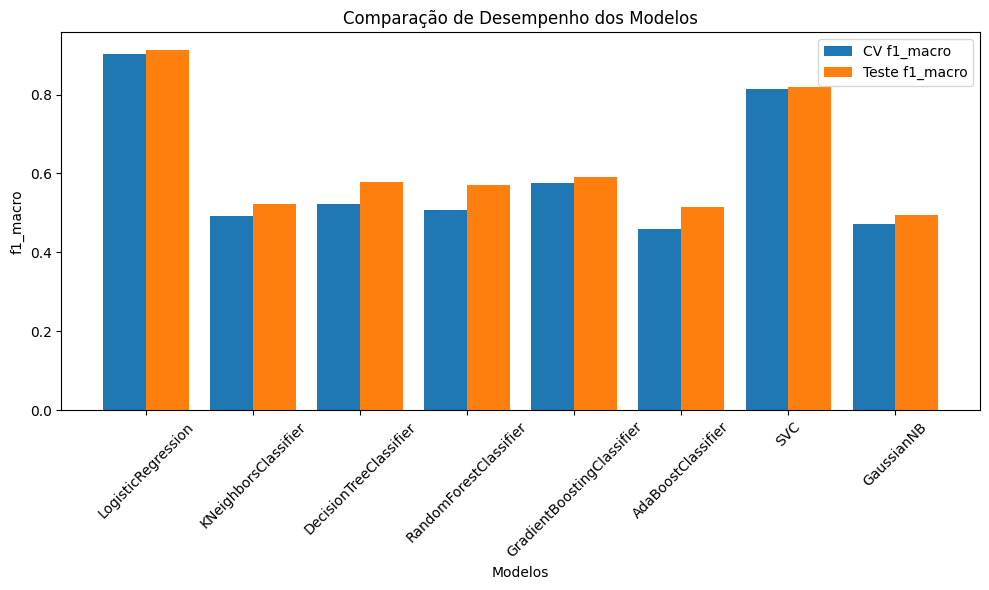

In [13]:
# Função que testa todos os modelos do dicionário usando GridSearchCV
def test_all_models(modelos, X_train, y_train, X_test, y_test):
    melhor_modelo_nome = None
    melhor_score = -np.inf
    melhor_modelo = None
    melhor_params = None
    resultados = {}

    for nome, info in modelos.items():
        print(f"Treinando {nome}...")
        # Cria pipeline com StandardScaler e o classificador
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", info["model"])
        ])
        # Adiciona o prefixo 'clf__' aos hiperparâmetros para o GridSearchCV
        param_grid = {f"clf__{param}": valores for param, valores in info["params"].items()}
        
        grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
        grid.fit(X_train, y_train)
        
        # Coleta resultados do GridSearch
        best_params = grid.best_params_
        cv_score = grid.best_score_
        test_score = f1_score(y_test, grid.predict(X_test), average='macro')
        
        resultados[nome] = {
            "cv_score": cv_score,
            "test_score": test_score,
            "best_params": best_params,
            "best_estimator": grid.best_estimator_
        }
        
        print(f"CV f1_macro: {cv_score:.4f}")
        print(f"Teste f1_macro: {test_score:.4f}")
        print(f"Melhores hiperparâmetros para {nome}: {best_params}\n")
        
        # Verifica se esse modelo foi o melhor até o momento
        if cv_score > melhor_score:
            melhor_score = cv_score
            melhor_modelo_nome = nome
            melhor_modelo = grid.best_estimator_
            melhor_params = best_params

    print("=================================================")
    print(f"Melhor modelo: {melhor_modelo_nome}")
    print(f"CV f1_macro: {melhor_score:.4f}")
    print(f"Melhores hiperparâmetros: {melhor_params}")
    print("=================================================")
    
    print(f"Avaliação do melhor modelo ({melhor_modelo_nome}) no conjunto de teste:")
    evaluate_model(melhor_modelo, X_test, y_test)
    
    # Cria gráfico comparativo de desempenho entre CV e teste
    nomes_modelos = list(resultados.keys())
    cv_scores = [resultados[modelo]["cv_score"] for modelo in nomes_modelos]
    test_scores = [resultados[modelo]["test_score"] for modelo in nomes_modelos]
    
    x = range(len(nomes_modelos))
    plt.figure(figsize=(10, 6))
    plt.bar(x, cv_scores, width=0.4, label="CV f1_macro", align="center")
    plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label="Teste f1_macro", align="center")
    plt.xticks([i + 0.2 for i in x], nomes_modelos, rotation=45)
    plt.xlabel("Modelos")
    plt.ylabel("f1_macro")
    plt.title("Comparação de Desempenho dos Modelos")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return melhor_modelo, resultados

# Executa a busca e avaliação de todos os modelos
melhor_modelo, resultados = test_all_models(modelos, X_train, y_train, X_test, y_test)


- O melhor modelo identificado foi o LogisticRegression, com o mais alto CV f1_macro (0.9083).

- A avaliação final no conjunto de teste confirmou seu desempenho robusto, evidenciado por uma matriz de confusão e relatório de classificação que demonstram f1-scores em torno de 0.91 para ambas as classes, reforçando sua capacidade de generalização.

In [16]:
# Salvar o melhor modelo para uso na API
joblib.dump(melhor_modelo, "bitcoin_model.pkl")
print("Melhor modelo treinado e salvo como 'bitcoin_model.pkl'")

Melhor modelo treinado e salvo como 'bitcoin_model.pkl'
